In [85]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from geopandas import GeoDataFrame
from geopandas.plotting import plot_polygon_collection
from shapely.geometry import shape, mapping, Point
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import json
import math

# Import data

In [2]:
# Define dataset
dataset = "commuter"

In [88]:
# Cost matrix
cost_matrix = np.loadtxt('../data/input/{}/cost_matrix.txt'.format(dataset))
# Origin supply
origin_supply = np.loadtxt('../data/input/{}/origin_supply.txt'.format(dataset))
# Destination demand
destination_demand = np.loadtxt('../data/input/{}/destination_demand.txt'.format(dataset))
# Origin-destination matrix for validation
od_matrix = np.loadtxt('../data/input/{}/od_matrix.txt'.format(dataset))

# Borough names
boroughs = np.loadtxt('../data/input/{}/origins-destinations.txt'.format(dataset),dtype=str)
# Borough polygons
borough_polygons = gpd.read_file('../data/input/{}/borough_coordinates.json'.format(dataset))
# Inferred flows through C function
c_inferred_flows = np.loadtxt('../data/output/{}/c_inferred_flows.txt'.format(dataset))

In [4]:
# Store total flow \sum_{i=1}^N \sum_{j=1}^M T_{ij}
total_flow = np.sum(origin_supply) # or equivalently np.sum(destination_demand)

In [5]:
# Select first num_zones zones
num_zones = cost_matrix.shape[0]

# Take subset of data
cost_matrix = cost_matrix[:num_zones,:num_zones]
od_matrix = od_matrix[:num_zones,:num_zones]
origin_supply = origin_supply[:num_zones]
destination_demand = destination_demand[:num_zones]

N,M = cost_matrix.shape

# Infer flows, i.e. origin-destination matrix

In [47]:
# Flags for print statements below
show_params = False
show_flows = True

# Set parameters
_beta = -13.78532656
_intercept = 1.0
A_initial = 1.0
B_initial = 1.0

# Set maximum_iterations
max_iterations = 100#int(1e4)

# Initialise list of parameters
parameters = {'beta':_beta,'intercept':_intercept,'A_initial':A_initial,'B_initial':B_initial}

In [48]:
def fast_flow_inference(orig_supply:np.array,dest_demand:np.array,cost_mat:np.array,params:dict,max_iters:int=1000,show_params:bool=False,show_flows:bool=False):    
    '''
    orig_supply [array]: supply generated at each origin zone 
    dest_demand [array]: demand generated at each destination zone
    cost_mat [array]: matrix of costs travelling from each origin to each destination
    show_params [boolean]: flag for printing parameter matrices A and B
    show_flows [boolean]: flag for printing flow from each origin to each destination
    max_iters [int]: maximum iterations for which system of equations should be solved
    '''
    # Note that
    # A_i = \exp(-lambda_i)/O_i
    # B_j = \exp(-kappa_j)/D_j

    
    # Get dimensions of cost matrix
    N,M = cost_mat.shape
    
    # Unpack parameters
    beta = params['beta']
    intercept = params['intercept']
    A = np.ones(N) * params['A_initial']
    B = np.ones(M) * params['B_initial']
    
    # Initialise empty flow matrix
    flows = np.zeros((N,M))
    
    for n in tqdm(range(N)):
        for m in range(M):
            # Solve normalising factors iteratively
            t = 0
            while (t < max_iters - 1):
                # Use initial values of lambda and kappa parameters
                
                # Update $A_i$
                # $A_i = 1 / \sum_{p=0}^M B_j D_j \exp(-\beta c_{pj})$
                temp = 0
                for mm in range(M):
                    temp += B[mm] * dest_demand[mm] * np.exp(-beta*cost_mat[n,mm])
                A[n] = 1. / temp

                # Update $B_j$
                # $B_j = 1 / \sum_{l=0}^N A_i O_i \exp(-\beta c_{lj})$
                temp = 0
                for nn in range(N):
                    temp += A[nn] * orig_supply[nn] * np.exp(-beta*cost_mat[nn,m])
                B[m] = 1. / temp

                # Increment number of iterations
                t += 1

            # Print statement
            if show_params:
                print('A',A[n])
                print('B',B[m])
            
            # Add solution for flows: $T_{ij} = A_i B_j O_i D_j \exp(-\beta c_{ij})$
            flows[n,m] = int(_intercept*A[n]*B[m]*orig_supply[n]*dest_demand[m]*np.exp(-beta*cost_mat[n,m]))

            # Print statement
            if show_flows:
                print('Flow',flows[n,m])

    return flows

In [49]:
def slow_flow_inference(orig_supply:np.array,dest_demand:np.array,cost_mat:np.array,params:dict,max_iters:int=1000,show_params:bool=False,show_flows:bool=False):    
    '''
    orig_supply [array]: supply generated at each origin zone 
    dest_demand [array]: demand generated at each destination zone
    cost_mat [array]: matrix of costs travelling from each origin to each destination
    show_params [boolean]: flag for printing parameter matrices A and B
    show_flows [boolean]: flag for printing flow from each origin to each destination
    max_iters [int]: maximum iterations for which system of equations should be solved
    '''
    # Note that
    # A_i = \exp(-lambda_i)/O_i
    # B_j = \exp(-kappa_j)/D_j

    
    # Get dimensions of cost matrix
    N,M = cost_mat.shape
    
    # Unpack parameters
    beta = params['beta']
    A = np.ones((max_iters,N)) * params['A_initial']
    B = np.ones((max_iters,M)) * params['B_initial']
    
    # Initialise empty flow matrix
    flows = np.zeros((N,M))
    
    for n in tqdm(range(N)):
        for m in range(M):
            # Solve normalising factors iteratively
            t = 0
            while (t < max_iters - 1):
                # Use initial values of lambda and kappa parameters
                if t == 0:
                    # Update $A_i$
                    # $A_i = 1 / \sum_{p=0}^M B_j D_j \exp(-\beta c_{pj})$
                    A_i_inverse = 0
                    for mm in range(M):
                        A_i_inverse += B[t,mm] * dest_demand[mm] * np.exp(-beta*cost_mat[n,mm])
                    A[t+1,n] = 1 / A_i_inverse

                    # Update $B_j$
                    # $B_j = 1 / \sum_{l=0}^N A_i O_i \exp(-\beta c_{lj})$
                    B_j_inverse = 0
                    for nn in range(N):
                        B_j_inverse += A[t,nn] * orig_supply[nn] * np.exp(-beta*cost_mat[nn,m])
                    B[t+1,m] = 1 / B_j_inverse
                # Use values of lambda and kappa parameters from previous iterations
                else:
                    # Update $A_i$
                    # $A_i = 1 / \sum_{p=0}^M B_j D_j \exp(-\beta c_{pj})$
                    A_i_inverse = 0
                    for mm in range(M):
                        A_i_inverse += B[t-1,mm] * dest_demand[mm] * np.exp(-beta*cost_mat[n,mm])
                    A[t+1,n] = 1 / A_i_inverse

                    # Update $B_j$
                    # $B_j = 1 / \sum_{l=0}^N A_i O_i \exp(-\beta c_{lj})$
                    B_j_inverse = 0
                    for nn in range(N):
                        B_j_inverse += A[t-1,nn] * orig_supply[nn] * np.exp(-beta*cost_mat[nn,m])
                    B[t+1,m] = 1 / B_j_inverse
                # Increment number of iterations
                t += 1

            # Print statement
            if show_params:
                print('A',A[t,:])
                print('B',B[t,:])
            
            # Add solution for flows: $T_{ij} = A_i B_j O_i D_j \exp(-\beta c_{ij})$
            flows[n,m] = int(A[max_iters-1,n]*B[max_iters-1,m]*orig_supply[n]*dest_demand[m]*np.exp(-beta*cost_mat[n,m]))

            # Print statement
            if show_flows:
                print('Flow',flows[n,m])

    return flows

In [50]:
python_inferred_flows = fast_flow_inference(origin_supply,destination_demand,cost_matrix,parameters,max_iterations)

100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


In [51]:
# Get total inferred supply and demand for origins and destinations, respectively
inferred_supply = np.sum(python_inferred_flows,axis=1)
inferred_demand = np.sum(python_inferred_flows,axis=0)

In [52]:
print('Origin supply inferred',inferred_supply)
print('Destination demand inferred',inferred_demand)

Origin supply inferred [ 11195. 115781.  87835. 100116. 120480.  76914.   3669. 128115. 121098.
  99947.  79741.  68674.  70721.  81882.  78222.  96822. 100515.  85378.
  69354.  61081.  57584. 113861. 100720.  79088.  75764.  91276.  69676.
  94129.  70021.  64433.  85080. 120299.  74423.]
Destination demand inferred [ 44171.  81882.  50963.  70042.  83299. 161451. 188278.  99955.  87896.
  74795.  54126.  56788.  72809.  50929.  51310.  63592. 117731.  78479.
 100297.  70150.  44748.  74364.  50043.  45919.  55745.  57044.  48149.
  95448.  48020. 113716.  51327.  67495. 342933.]


In [53]:
print('Total flow inferred',np.sum(inferred_demand))
print('Total flow actual',np.sum(destination_demand))

Total flow inferred 2753894.0
Total flow actual 2796999.0


In [13]:
pd.DataFrame(python_inferred_flows)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11195.0
1,2786.0,132.0,4338.0,219.0,9840.0,1758.0,9113.0,12971.0,642.0,800.0,...,2661.0,3582.0,2880.0,924.0,8139.0,4246.0,7159.0,1815.0,2961.0,7459.0
2,5.0,4355.0,1.0,4370.0,39.0,8373.0,4139.0,929.0,5084.0,1303.0,...,1901.0,45.0,35.0,2469.0,1220.0,1300.0,628.0,219.0,3354.0,17450.0
3,3319.0,250.0,4300.0,52.0,7525.0,2233.0,9919.0,7123.0,92.0,2045.0,...,991.0,4214.0,3868.0,184.0,6904.0,1708.0,8097.0,2867.0,1236.0,5769.0
4,93.0,8275.0,30.0,6409.0,27.0,12910.0,5830.0,382.0,6631.0,3833.0,...,1523.0,195.0,283.0,2600.0,1255.0,834.0,1165.0,795.0,3190.0,23213.0
5,2378.0,840.0,3193.0,957.0,5928.0,697.0,3205.0,7076.0,2057.0,1550.0,...,1847.0,2435.0,2591.0,1554.0,3289.0,2861.0,3616.0,1567.0,1709.0,1863.0
6,49.0,161.0,61.0,167.0,107.0,130.0,16.0,168.0,262.0,91.0,...,99.0,37.0,54.0,146.0,30.0,115.0,34.0,34.0,109.0,274.0
7,1004.0,9511.0,615.0,5300.0,326.0,13573.0,8124.0,117.0,4779.0,8431.0,...,541.0,1344.0,2000.0,1465.0,1625.0,202.0,3361.0,2917.0,1554.0,20369.0
8,3725.0,655.0,4366.0,84.0,6752.0,4443.0,14317.0,5518.0,25.0,3320.0,...,693.0,5044.0,4656.0,43.0,8205.0,1062.0,10426.0,3938.0,1179.0,9391.0
9,498.0,728.0,1057.0,1796.0,3744.0,3261.0,4849.0,9418.0,3315.0,92.0,...,4550.0,673.0,392.0,3080.0,4307.0,5436.0,1948.0,186.0,5521.0,13317.0


In [14]:
pd.DataFrame(c_inferred_flows)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,2.0,1334.0,13.0,2158.0,161.0,1502.0,773.0,830.0,5164.0,292.0,...,947.0,20.0,9.0,2712.0,353.0,953.0,178.0,52.0,1123.0,3601.0
1,7240.0,83.0,12392.0,186.0,15438.0,544.0,2575.0,8368.0,980.0,460.0,...,1373.0,3194.0,4287.0,1235.0,2601.0,2700.0,2967.0,1139.0,1135.0,2140.0
2,15.0,2624.0,4.0,3552.0,67.0,2585.0,1226.0,647.0,7735.0,796.0,...,1055.0,46.0,61.0,3486.0,443.0,917.0,301.0,159.0,1398.0,5511.0
3,8263.0,131.0,11834.0,36.0,11431.0,591.0,2556.0,4363.0,118.0,1070.0,...,451.0,3648.0,5580.0,211.0,2088.0,989.0,3226.0,1724.0,415.0,1447.0
4,288.0,5075.0,104.0,5326.0,52.0,4131.0,1867.0,295.0,10321.0,2460.0,...,882.0,219.0,529.0,3744.0,491.0,622.0,602.0,619.0,1371.0,7407.0
5,4604.0,307.0,6891.0,473.0,7095.0,130.0,606.0,3385.0,1888.0,586.0,...,622.0,1598.0,2843.0,1291.0,740.0,1258.0,1073.0,700.0,417.0,330.0
6,91.0,56.0,126.0,79.0,124.0,23.0,2.0,78.0,234.0,33.0,...,32.0,24.0,59.0,120.0,6.0,50.0,10.0,15.0,26.0,48.0
7,3330.0,6187.0,2259.0,4572.0,665.0,4433.0,2635.0,95.0,7642.0,5717.0,...,311.0,1516.0,3805.0,2105.0,627.0,152.0,1725.0,2292.0,655.0,6299.0
8,10250.0,358.0,13359.0,61.0,11484.0,1223.0,3905.0,3780.0,34.0,1907.0,...,342.0,4847.0,7544.0,53.0,2703.0,686.0,4568.0,2643.0,426.0,2502.0
9,1527.0,442.0,3618.0,1460.0,7205.0,1000.0,1475.0,7443.0,5018.0,58.0,...,2551.0,706.0,691.0,4248.0,1565.0,4015.0,926.0,135.0,2227.0,3868.0


In [15]:
pd.DataFrame(od_matrix)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,20434.0,194.0,96.0,178.0,66.0,1500.0,3641.0,104.0,188.0,410.0,...,67.0,4460.0,5940.0,28.0,926.0,38.0,4069.0,1047.0,165.0,3280.0
1,96.0,44045.0,34.0,5467.0,76.0,12080.0,7709.0,148.0,1573.0,4098.0,...,146.0,387.0,305.0,229.0,1792.0,44.0,2511.0,555.0,536.0,16330.0
2,362.0,132.0,33681.0,144.0,4998.0,2470.0,6580.0,710.0,188.0,123.0,...,190.0,574.0,111.0,90.0,4666.0,170.0,2825.0,222.0,618.0,7692.0
3,40.0,6124.0,28.0,32105.0,66.0,8105.0,4145.0,187.0,6703.0,426.0,...,203.0,279.0,116.0,396.0,1565.0,56.0,1655.0,210.0,669.0,16418.0
4,134.0,162.0,3199.0,201.0,51289.0,3780.0,9855.0,6268.0,293.0,84.0,...,647.0,419.0,100.0,191.0,6057.0,796.0,3385.0,196.0,1371.0,12802.0
5,36.0,1496.0,32.0,1350.0,60.0,26535.0,8795.0,147.0,643.0,295.0,...,139.0,290.0,84.0,195.0,1784.0,54.0,2614.0,204.0,588.0,18829.0
6,6.0,14.0,0.0,16.0,0.0,335.0,1627.0,3.0,9.0,6.0,...,6.0,16.0,0.0,6.0,103.0,3.0,266.0,16.0,16.0,602.0
7,85.0,204.0,300.0,329.0,5152.0,3248.0,5925.0,65033.0,405.0,120.0,...,3521.0,202.0,64.0,480.0,4513.0,6744.0,2000.0,130.0,4270.0,10583.0
8,30.0,967.0,33.0,5263.0,91.0,4547.0,4855.0,182.0,42004.0,223.0,...,361.0,229.0,79.0,1578.0,1328.0,65.0,1420.0,127.0,944.0,13967.0
9,217.0,5642.0,52.0,1038.0,76.0,5588.0,5212.0,136.0,626.0,44370.0,...,114.0,661.0,538.0,98.0,1253.0,47.0,2141.0,1710.0,314.0,9052.0


In [17]:
# Compute error
square_error = 0
for i in range(N):
    for j in range(M):
        square_error += (python_inferred_flows[i,j] - od_matrix[i,j])**2
print("RMSE", math.sqrt(square_error/(N*M)))

RMSE 6679.0089803500005


# Learn parameters using PySal

In [18]:
import pysal

## Import data as dataframe

In [19]:
# Cost matrix
cost_matrix_df = pd.read_csv('../data/input/{}/cost_matrix.csv'.format(dataset),index_col=0)
# Origin supply
origin_supply_df = pd.read_csv('../data/input/{}/origin_supply.csv'.format(dataset),index_col=0)
# Destination demand
destination_demand_df = pd.read_csv('../data/input/{}/destination_demand.csv'.format(dataset),index_col=0)
# Origin-destination matrix for validation
od_matrix_df = pd.read_csv('../data/input/{}/od_matrix.csv'.format(dataset),index_col=0)

## Reshape data

In [20]:
od_data = pd.DataFrame(columns=['Origin','Destination','Cost','Flow','OriginSupply','DestinationDemand'])

In [21]:
# Loop over origins and destinations
for orig in tqdm(cost_matrix_df.columns):
    for dest in cost_matrix_df.columns:
        # Add row properties
        new_row = pd.Series({"Origin": orig, 
                             "Destination": dest, 
                             "Cost": cost_matrix_df.loc[orig,dest],
                             "Flow": od_matrix_df.loc[orig,dest],
                             "OriginSupply": origin_supply_df.loc[orig,'Supply'],
                             "DestinationDemand":destination_demand_df.loc[dest,'Demand']})
        # Append row to dataframe
        od_data = od_data.append(new_row, ignore_index=True)

100%|██████████| 33/33 [00:06<00:00,  4.95it/s]


In [22]:
flows_flat = od_data.Flow.values.astype('int64') 
orig_supply_flat = od_data.OriginSupply.values.astype('int64')
dest_demand_flat = od_data.DestinationDemand.values.astype('int64')
cost_flat = od_data.Cost.values.astype('float64')

In [23]:
doubly = pysal.model.spint.Doubly(flows_flat, orig_supply_flat, dest_demand_flat, cost_flat, 'exp')

In [57]:
# Print optimised parameter
'distance coefficient',doubly.params[-1:][0]

('distance coefficient', -13.785326563646777)

In [55]:
'intercept',doubly.params[0]

('intercept', 6.650276665877912)

### Reconstruct predicted flows

In [25]:
pysal_flows = np.zeros((N,M))
for i in tqdm(range(N)):
    for j in range(M):
        pysal_flows[i][j] = doubly.yhat[i*M + j]

100%|██████████| 33/33 [00:00<00:00, 15832.99it/s]


In [26]:
pd.DataFrame(pysal_flows)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,13983.426758,280.008910,4062.753178,101.049109,1771.991340,1042.011657,2609.215460,559.666924,55.692630,892.283049,...,111.527745,3702.617121,7298.434878,38.974495,1289.392547,119.195392,2794.014498,1533.510812,228.300703,2014.906762
1,31.261861,29608.357133,28.904195,7730.536656,122.510114,18956.481725,5166.310056,366.079906,1934.028259,3740.561827,...,507.195913,153.430277,109.849511,564.328171,1156.215386,277.619858,1105.217546,464.335099,1489.420126,22358.303381
2,5075.116793,323.402598,25103.757658,139.480402,9697.793757,1376.193792,3737.318027,1630.401389,84.467428,744.609866,...,227.354160,3615.070110,2631.729225,68.892382,2335.358330,281.307819,3753.168556,1141.348603,416.629674,2991.242312
3,14.095468,9658.589017,15.575235,20178.592200,85.141204,8980.472224,2677.824742,361.300938,8222.365424,827.251928,...,793.428461,69.134526,43.432791,1696.604818,741.008253,390.000627,523.161450,157.854506,2092.545542,17016.117171
4,829.381320,513.595990,3633.624087,285.683676,38316.170366,2644.250980,7535.825991,10948.597549,194.397369,739.711431,...,834.755014,2366.821594,941.492189,196.983752,6477.312944,1273.557793,5755.805319,903.619932,1305.080684,6833.994630
5,11.502927,1874.349335,12.161573,710.702644,62.365699,18491.024145,5132.332248,211.718305,235.012814,686.278135,...,261.732166,71.735318,38.754882,126.328033,950.659706,139.371396,715.226556,176.578296,948.414814,33858.956703
6,1.074233,19.051362,1.231751,7.903576,6.628675,191.411275,1965.232736,17.113361,3.537145,22.357799,...,9.249775,8.762788,3.481221,2.532971,196.458804,6.539173,140.252113,15.018975,27.792405,433.056696
7,105.707548,619.311684,246.516101,489.213495,4418.167677,3622.421575,7850.966680,49814.921267,385.949640,468.090963,...,3472.797925,502.514305,192.503486,514.973177,7456.095339,7652.460725,2955.929507,358.898411,4015.635724,11814.141964
8,11.149579,3468.011918,13.537062,11800.774106,83.149275,4262.030068,1719.986666,409.086383,27906.067685,455.579093,...,1028.033276,51.056014,31.524953,6525.319663,561.753439,551.451142,362.519850,101.013852,2000.815617,9656.842317
9,135.970780,5105.482713,90.833517,903.719634,240.831129,9473.431843,8275.294502,377.656398,346.773572,27068.457182,...,250.504490,636.826303,625.223985,150.566904,1762.891770,171.272653,3247.029166,3591.826633,696.770540,11350.608121


# Visualise actual and inferred O/D matrices

In [28]:
# Actual flows: od_matrix
# PySal flows: pysal_flows
# My C algorithm's flows: c_inferred_flows
# My Python algorithm's flows: python_inferred_flows

# Decide which data to plot
heatmap_data = python_inferred_flows.astype(int)
# Choose filename
filename = "Python_inferred_flows"

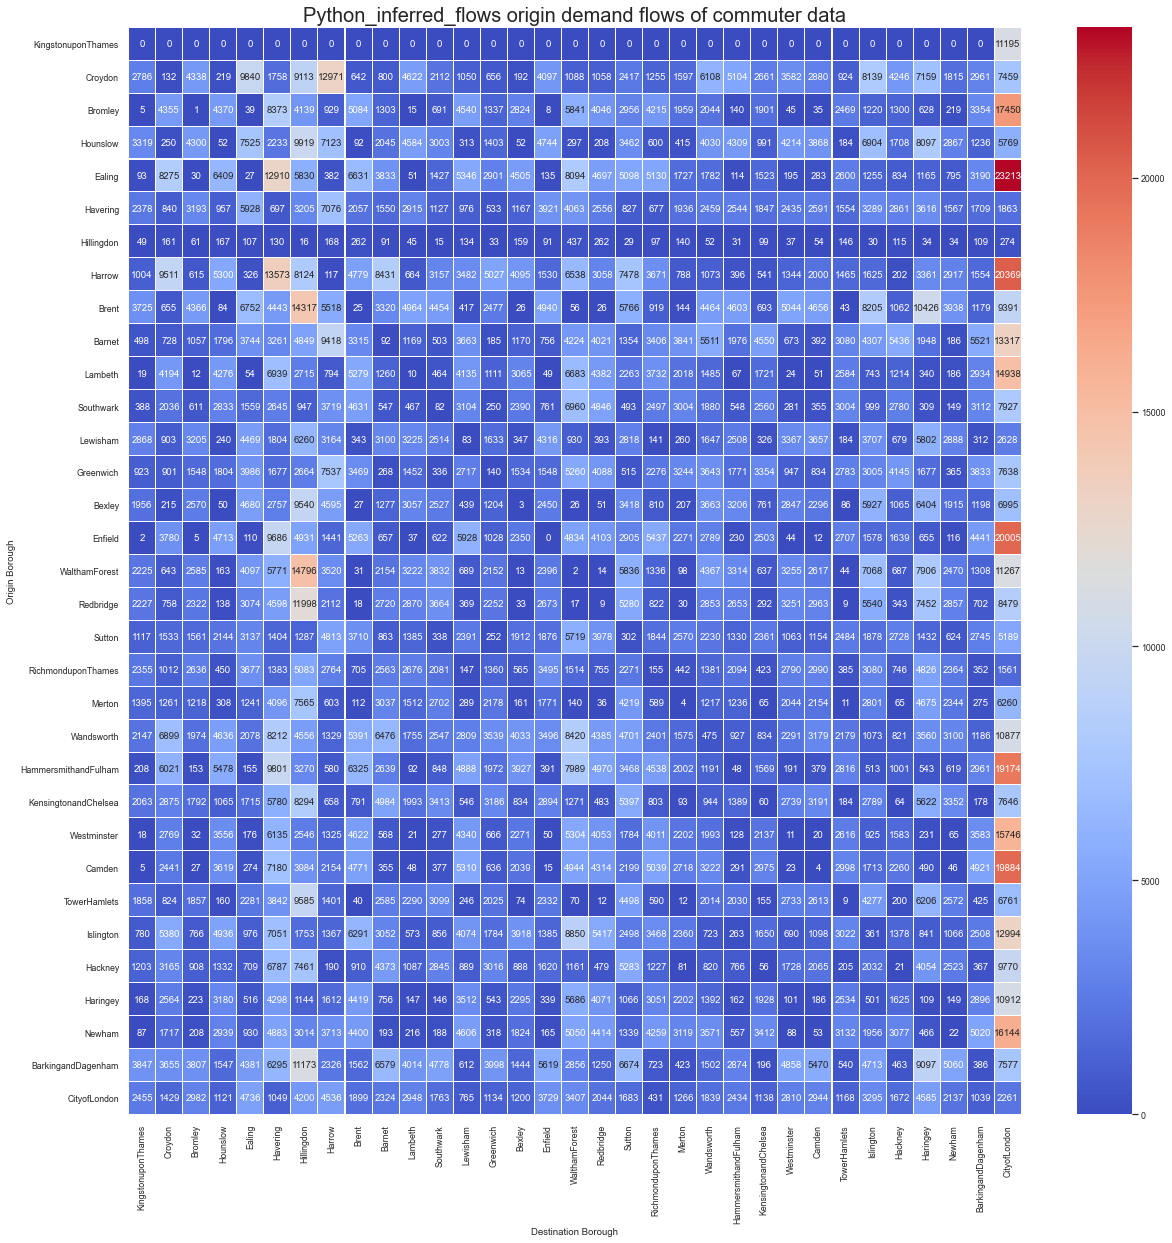

In [32]:
# Change font scaling
sns.set(font_scale=0.8)
# Set plot size
plt.figure(figsize=(20,20))
# Add heatmap
flow_heatmap = sns.heatmap(heatmap_data,
                            annot=True,
                            cmap="coolwarm",
                            fmt="d",
                            xticklabels=boroughs,
                            yticklabels=boroughs,
                            linewidths=.05)
# Add x,y axes labels
plt.xlabel("Destination Borough")
plt.ylabel("Origin Borough")
# Add title
plt.title('{} origin demand flows of {} data'.format(filename,dataset), fontsize=20)

# Save figure to output
plt.savefig('../data/output/{}/figures/{}.png'.format(dataset,(filename+"_flows")))

# Visualise origin and destination demand

In [201]:
borough_polygons.loc[:,'pysal_inferred_origin_supply'] = np.sum(pysal_flows,axis=1)
borough_polygons.loc[:,'pysal_inferred_destination_demand'] = np.sum(pysal_flows,axis=0)
borough_polygons.loc[:,'actual_origin_supply'] = np.sum(od_matrix,axis=1)
borough_polygons.loc[:,'actual_destination_demand'] = np.sum(od_matrix,axis=0)
borough_polygons.loc[:,'destination_demand_pysal_error'] = np.sum(od_matrix,axis=0) - np.sum(pysal_flows,axis=0)
borough_polygons.loc[:,'origin_supply_pysal_error'] = np.sum(od_matrix,axis=1) - np.sum(pysal_flows,axis=1)

In [205]:
# Choose variable to plot
var = 'origin_supply_pysal_error'
colormap = 'YlOrRd_r'#'winter'

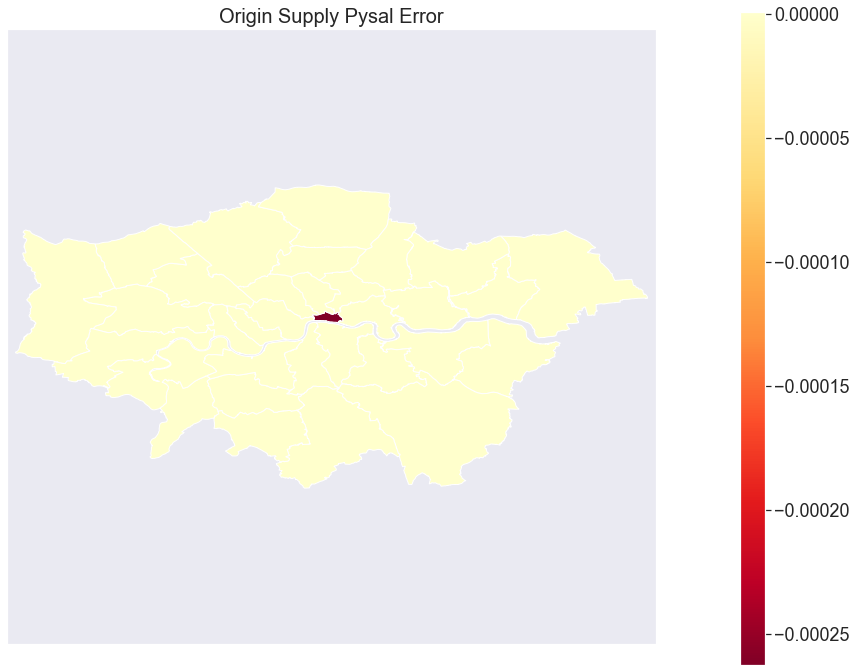

<Figure size 432x288 with 0 Axes>

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='datalim')
ax.set_title(var.replace('_',' ').title(),fontsize=20)

borough_polygons.plot(column=var,
                      cmap=colormap, 
                      ax=ax, 
                      legend=False,
                      vmin=min(borough_polygons[var]), 
                      vmax=max(borough_polygons[var]),
                      legend_kwds={'label': "Number of people",
                                   'orientation': "horizontal"})
# Add new axes manually and change their font size
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min(borough_polygons[var]), 
                                                             vmax=max(borough_polygons[var])))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=18) 

# Produce tight layout
ax.margins(0)
ax.apply_aspect()
bbox = ax.get_window_extent().inverse_transformed(fig.transFigure)
w,h = fig.get_size_inches()
fig.set_size_inches(w*bbox.width, h*bbox.height)

plt.show()
plt.savefig('../data/output/{}/figures/{}.png'.format(dataset,var))

# Compute validation metrics

## PySAL method comparison with true baseline

In [210]:
sum_absolute_error = 0
for i in tqdm(range(N)):
    for j in range(M):
        sum_absolute_error += abs(od_matrix[i][j] - pysal_flows[i][j])
print('Mean absolute error', sum_absolute_error/(N*M))

100%|██████████| 33/33 [00:00<00:00, 7602.13it/s]

Mean absolute error 1098.8793778125585
